Δημιουργία πλέγματος 3x3...
Το παζλ ανακατεύτηκε!


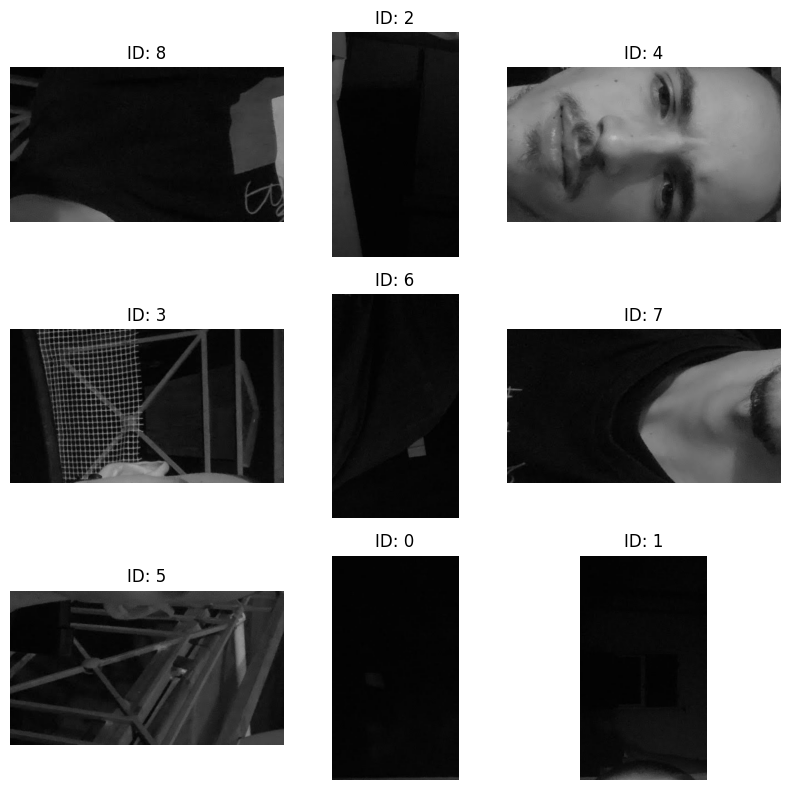


Λεπτομέρειες 1ου κομματιού (Border Strips):


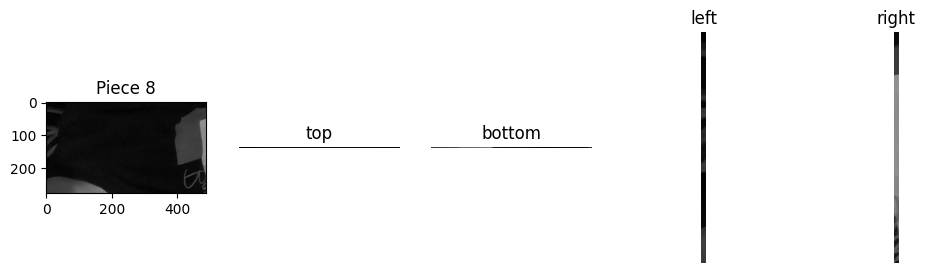

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

# --- 1. Η Κλάση του Κομματιού (PuzzlePiece) ---
class PuzzlePiece:
    def __init__(self, piece_id, image_data, grid_position, border_width=5):
        """
        Αναπαριστά ένα μοναδικό κομμάτι του παζλ.
        """
        self.id = piece_id
        self.image = image_data
        self.true_grid_pos = grid_position # Η σωστή θέση στο grid (Ground Truth)
        self.wb = border_width # Το πλάτος των συνόρων (Border Strips)

        # Εδώ θα αποθηκεύσουμε τα χαρακτηριστικά (Features) αργότερα
        self.features = {
            'tile': {},
            'sides': {'top': {}, 'bottom': {}, 'left': {}, 'right': {}}
        }

        # Εξαγωγή των Border Strips κατά την αρχικοποίηση
        self.border_strips = self._extract_border_strips()

    def _extract_border_strips(self):
        """Κόβει τις 4 λωρίδες (top, bottom, left, right) από το κομμάτι."""
        h, w, _ = self.image.shape
        wb = self.wb
        strips = {}

        # Slicing με βάση τους ορισμούς του PDF
        strips['top'] = self.image[0:wb, :, :]
        strips['bottom'] = self.image[h-wb:h, :, :]
        strips['left'] = self.image[:, 0:wb, :]
        strips['right'] = self.image[:, w-wb:w, :]
        return strips

    def rotate(self, angle):
        """Περιστρέφει το κομμάτι και επαναϋπολογίζει τα strips."""
        k = angle // 90
        # rot90 στο numpy: k φορές περιστροφή (default είναι counter-clockwise)
        # Χρησιμοποιούμε axes=(0,1) για χωρική περιστροφή εικόνας
        self.image = np.rot90(self.image, k=(3 if k==1 else 2 if k==2 else 1))

        # Πρέπει να ξανακόψουμε τα strips γιατί η εικόνα άλλαξε
        self.border_strips = self._extract_border_strips()

        # Καθαρίζουμε τα features γιατί πλέον είναι λάθος μετά την περιστροφή
        self.features = {'tile': {}, 'sides': {'top': {}, 'bottom': {}, 'left': {}, 'right': {}}}

    def visualize(self):
        """Δείχνει το κομμάτι και τα border strips του."""
        fig, axs = plt.subplots(1, 5, figsize=(12, 3))
        axs[0].imshow(self.image)
        axs[0].set_title(f"Piece {self.id}")

        stripped = ['top', 'bottom', 'left', 'right']
        for i, s in enumerate(stripped):
            axs[i+1].imshow(self.border_strips[s])
            axs[i+1].set_title(s)
            axs[i+1].axis('off')
        plt.show()

# --- 2. Ο Γεννήτορας του Παζλ (PuzzleGenerator) ---
class PuzzleGenerator:
    def __init__(self, P, Q, border_width=5):
        self.P = P # Γραμμές
        self.Q = Q # Στήλες
        self.wb = border_width
        self.pieces = []

    def from_image(self, image_path):
        # Φόρτωση εικόνας
        full_image = cv2.imread(image_path)
        if full_image is None:
            raise FileNotFoundError(f"Η εικόνα '{image_path}' δεν βρέθηκε! Ελέγξτε το όνομα.")

        # Μετατροπή BGR (OpenCV) -> RGB (Matplotlib)
        full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

        H, W, _ = full_image.shape
        h_tile = H // self.P
        w_tile = W // self.Q

        # Crop για να διαιρείται ακριβώς
        full_image = full_image[:h_tile*self.P, :w_tile*self.Q]

        self.pieces = []
        cnt = 0

        print(f"Δημιουργία πλέγματος {self.P}x{self.Q}...")

        # Κόψιμο της εικόνας [cite: 186-194]
        for r in range(self.P):
            for c in range(self.Q):
                y_start, y_end = r * h_tile, (r + 1) * h_tile
                x_start, x_end = c * w_tile, (c + 1) * w_tile

                tile_img = full_image[y_start:y_end, x_start:x_end]

                # Δημιουργία αντικειμένου
                piece = PuzzlePiece(cnt, tile_img, (r, c), self.wb)

                # Τυχαία Περιστροφή
                rotations = [0, 90, 180, 270]
                angle = random.choice(rotations)
                if angle != 0:
                    piece.rotate(angle)

                self.pieces.append(piece)
                cnt += 1

        # Ανακάτεμα (Shuffling)
        random.shuffle(self.pieces)
        print("Το παζλ ανακατεύτηκε!")
        return self.pieces

    def visualize_grid(self):
        """Εμφανίζει όλα τα κομμάτια σε πλέγμα."""
        if not self.pieces: return

        fig, axs = plt.subplots(self.P, self.Q, figsize=(8, 8))
        for i, ax in enumerate(axs.flat):
            if i < len(self.pieces):
                ax.imshow(self.pieces[i].image)
                ax.set_title(f"ID: {self.pieces[i].id}")
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

# --- 3. Κώδικας Εκτέλεσης (Main) ---

# ΣΗΜΑΝΤΙΚΟ: Άλλαξε το 'my_photo.jpg' με το όνομα της εικόνας που ανέβασες!
img_filename = "my_photo.jpg"  # <--- ΓΡΑΨΕ ΕΔΩ ΤΟ ΟΝΟΜΑ ΤΟΥ ΑΡΧΕΙΟΥ ΣΟΥ

if os.path.exists(img_filename):
    # Δημιουργία γεννήτορα (3x3 κομμάτια, 5 pixels border)
    gen = PuzzleGenerator(P=3, Q=3, border_width=5)

    # Δημιουργία παζλ
    pieces = gen.from_image(img_filename)

    # Εμφάνιση αποτελέσματος
    gen.visualize_grid()

    # Εμφάνιση λεπτομερειών για το πρώτο κομμάτι (για έλεγχο)
    print("\nΛεπτομέρειες 1ου κομματιού (Border Strips):")
    pieces[0].visualize()
else:
    print(f"ΣΦΑΛΜΑ: Το αρχείο '{img_filename}' δεν βρέθηκε στο Colab.")
    print("Βεβαιώσου ότι το ανέβασες στο φακελάκι αριστερά και ότι το όνομα είναι σωστό.")

In [2]:
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

class FeatureExtractor:
    def __init__(self, color_bins=8, gabor_frequencies=[0.1, 0.25], gabor_orientations=[0, 45, 90, 135]):
        """
        Υπολογίζει τα features για κάθε κομμάτι.
        Parameters:
        - color_bins: Πόσα 'καλάθια' θα έχει το ιστόγραμμα (π.χ. 8 τιμές ανά χρώμα).
        - gabor_frequencies/orientations: Παράμετροι για τα φίλτρα υφής .
        """
        self.bins = color_bins
        # Δημιουργία της τράπεζας φίλτρων Gabor (Filter Bank)
        self.gabor_kernels = self._build_gabor_bank(gabor_frequencies, gabor_orientations)

    def _build_gabor_bank(self, freqs, thetas):
        """Δημιουργεί τα Gabor kernels (πυρήνες φίλτρων)."""
        kernels = []
        for frequency in freqs:
            for theta_deg in thetas:
                theta = np.deg2rad(theta_deg)
                # Δημιουργία kernel (μόνο το real part χρειάζεται συνήθως για υφή)
                kernel = np.real(gabor_kernel(frequency, theta=theta))
                kernels.append(kernel)
        return kernels

    def compute_color_hist(self, image):
        """Υπολογίζει το Normalized Color Histogram [cite: 326-330]."""
        # Μετατροπή σε HSV (συχνά καλύτερο από RGB για παζλ) ή παραμονή σε RGB.
        # Θα χρησιμοποιήσουμε RGB για απλότητα όπως λέει η εκφώνηση.
        hist_features = []

        # Για κάθε κανάλι (R, G, B)
        for channel_id in range(3):
            # Υπολογισμός ιστογράμματος
            hist, _ = np.histogram(image[:, :, channel_id], bins=self.bins, range=(0, 255))

            # Κανονικοποίηση (ώστε το άθροισμα να είναι 1) [cite: 326]
            if hist.sum() > 0:
                hist = hist / hist.sum()

            hist_features.extend(hist)

        return np.array(hist_features)

    def compute_texture(self, image):
        """Υπολογίζει τα Texture Features με Gabor Filters [cite: 378-392]."""
        # Μετατροπή σε Grayscale γιατί η υφή δεν χρειάζεται χρώμα
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        texture_feats = []

        # Εφαρμογή κάθε φίλτρου
        for kernel in self.gabor_kernels:
            # Convolution (Συνέλιξη)
            filtered = ndi.convolve(gray, kernel, mode='wrap')

            # Υπολογισμός στατιστικών (Mean, Energy, Std) [cite: 381-385]
            mu = filtered.mean()
            energy = (filtered**2).mean()
            std = filtered.std()

            texture_feats.extend([mu, energy, std])

        return np.array(texture_feats)

    def process_piece(self, piece):
        """Εφαρμόζει την εξαγωγή σε ΟΛΟ το κομμάτι και στις ΠΛΕΥΡΕΣ του."""

        # 1. Global Tile Features (Ολόκληρο το κομμάτι)
        piece.features['tile']['color'] = self.compute_color_hist(piece.image)
        piece.features['tile']['texture'] = self.compute_texture(piece.image)

        # 2. Side Features (Για κάθε πλευρά: top, bottom, left, right) [cite: 626-628]
        for side_name, strip_img in piece.border_strips.items():
            # Έλεγχος: Αν το strip είναι πολύ μικρό (π.χ. λάθος στο crop), βάζουμε μηδενικά
            if strip_img.size == 0:
                piece.features['sides'][side_name]['color'] = np.zeros(self.bins*3)
                piece.features['sides'][side_name]['texture'] = np.zeros(len(self.gabor_kernels)*3)
                continue

            # Υπολογισμός Color για τη λωρίδα
            piece.features['sides'][side_name]['color'] = self.compute_color_hist(strip_img)

            # Υπολογισμός Texture για τη λωρίδα
            piece.features['sides'][side_name]['texture'] = self.compute_texture(strip_img)

# --- ΕΚΤΕΛΕΣΗ ΚΑΙ ΕΛΕΓΧΟΣ ---

# Δημιουργία του Extractor
print("Εκκίνηση Feature Extraction...")
extractor = FeatureExtractor(color_bins=8) # 8 bins ανά χρώμα -> 24 features συνολικά για χρώμα

# Επεξεργασία όλων των κομματιών που φτιάξαμε στο προηγούμενο βήμα
# (Η λίστα 'pieces' υπάρχει στη μνήμη από το προηγούμενο κελί)
for p in pieces:
    extractor.process_piece(p)

print("Ολοκληρώθηκε!")
print("-" * 30)

# Έλεγχος: Ας δούμε τι υπολογίσαμε για το πρώτο κομμάτι
sample = pieces[0]
print(f"Features για το κομμάτι ID {sample.id}:")
print(f" - Global Color Vector Size: {sample.features['tile']['color'].shape}")
print(f" - Global Texture Vector Size: {sample.features['tile']['texture'].shape}")
print(f" - Top Side Color Vector: {sample.features['sides']['top']['color'].shape}")
print("\nΔείγμα (Top Side Color Histogram):")
print(np.round(sample.features['sides']['top']['color'], 2))

Εκκίνηση Feature Extraction...
Ολοκληρώθηκε!
------------------------------
Features για το κομμάτι ID 8:
 - Global Color Vector Size: (24,)
 - Global Texture Vector Size: (24,)
 - Top Side Color Vector: (24,)

Δείγμα (Top Side Color Histogram):
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
class AdjacencyScorer:
    def __init__(self, weight_color=0.7, weight_texture=0.3):
        """
        Υπολογίζει πόσο ταιριάζουν δύο πλευρές.
        weights: Πόσο σημαντικό θεωρούμε το χρώμα vs την υφή[cite: 763].
        """
        self.w_color = weight_color
        self.w_tex = weight_texture

        # Παράμετροι ευαισθησίας (lambda) για τη μετατροπή απόστασης σε σκορ
        self.lambda_color = 20.0
        self.lambda_tex = 0.5

    def _chi_square_distance(self, hist1, hist2):
        """Υπολογίζει την απόσταση Chi-Square για ιστογράμματα."""
        # Αποφεύγουμε διαίρεση με το μηδέν προσθέτοντας ελάχιστο 1e-10
        eps = 1e-10
        d = 0.5 * np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + eps))
        return d

    def _euclidean_distance(self, vec1, vec2):
        """Κλασική Ευκλείδεια απόσταση."""
        return np.linalg.norm(vec1 - vec2)

    def compute_score(self, piece_i, side_i, piece_j, side_j):
        """
        Υπολογίζει το C((i, side_i), (j, side_j))[cite: 775].
        Π.χ. Πόσο ταιριάζει η 'right' πλευρά του i με την 'left' του j.
        """
        # 1. Πάρε τα features
        feat_i = piece_i.features['sides'][side_i]
        feat_j = piece_j.features['sides'][side_j]

        # 2. Υπολογισμός Αποστάσεων [cite: 738]
        dist_color = self._chi_square_distance(feat_i['color'], feat_j['color'])
        dist_tex = self._euclidean_distance(feat_i['texture'], feat_j['texture'])

        # 3. Μετατροπή σε Similarity (0 έως 1) [cite: 750-752]
        sim_color = np.exp(-self.lambda_color * dist_color)
        sim_tex = np.exp(-self.lambda_tex * dist_tex)

        # 4. Τελικό Σταθμισμένο Σκορ [cite: 763]
        total_score = (self.w_color * sim_color) + (self.w_tex * sim_tex)

        return total_score

# --- ΔΟΚΙΜΗ ΤΟΥ SCORER ---

scorer = AdjacencyScorer(weight_color=0.8, weight_texture=0.2)

print("Υπολογισμός συμβατότητας μεταξύ τυχαίων κομματιών...\n")

# Ας πάρουμε δύο τυχαία κομμάτια από τη λίστα 'pieces'
p1 = pieces[0]
p2 = pieces[1]

# Ας συγκρίνουμε τη ΔΕΞΙΑ πλευρά του p1 με την ΑΡΙΣΤΕΡΗ του p2
score = scorer.compute_score(p1, 'right', p2, 'left')

print(f"Σκορ μεταξύ Piece {p1.id} (Right) και Piece {p2.id} (Left): {score:.4f}")

# Ας συγκρίνουμε το p1 με τον εαυτό του (θεωρητικά τέλειο ταίριασμα αν συγκρίνουμε ίδια πλευρά)
# Για έλεγχο: Συγκρίνουμε Right με Right (θα πρέπει να βγάλει 1.0)
perfect_score = scorer.compute_score(p1, 'right', p1, 'right')
print(f"Έλεγχος (Right vs Right του ίδιου κομματιού): {perfect_score:.4f} (Πρέπει να είναι 1.0)")

Υπολογισμός συμβατότητας μεταξύ τυχαίων κομματιών...

Σκορ μεταξύ Piece 8 (Right) και Piece 2 (Left): 0.0000
Έλεγχος (Right vs Right του ίδιου κομματιού): 1.0000 (Πρέπει να είναι 1.0)


Δημιουργία Solver (Robust)...
Ξεκινάει η επίλυση...
Seed: ID 0 στη θέση (0,0)
Θέση (0,1): ID 1 (Rot: 0) - Score: 0.8151
Θέση (0,2): ID 2 (Rot: 180) - Score: 0.7869
Θέση (1,0): ID 8 (Rot: 90) - Score: 0.0015
Θέση (1,1): ID 3 (Rot: 0) - Score: 0.4000
Θέση (1,2): ID 5 (Rot: 270) - Score: 0.3338
Θέση (2,0): ID 4 (Rot: 90) - Score: 0.0018
Θέση (2,1): ID 7 (Rot: 270) - Score: 0.0003
Θέση (2,2): ID 6 (Rot: 270) - Score: 0.0000


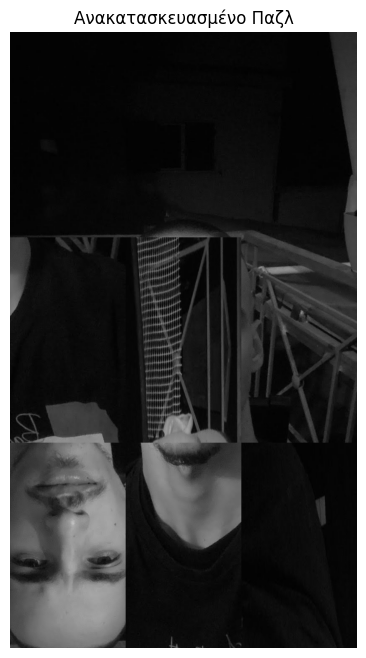

In [4]:
import copy
import cv2 # Σιγουρευόμαστε ότι έχουμε το cv2 για το resize

class GreedySolver:
    def __init__(self, pieces, P, Q, scorer, extractor):
        self.pieces = pieces
        self.P = P
        self.Q = Q
        self.scorer = scorer
        self.extractor = extractor
        self.grid = [[None for _ in range(Q)] for _ in range(P)]
        self.unused_ids = [p.id for p in pieces]

    def _get_piece_by_id(self, pid):
        for p in self.pieces:
            if p.id == pid:
                return p
        return None

    def solve(self):
        print("Ξεκινάει η επίλυση...")

        # --- SEED (0,0) ---
        seed_piece = None
        for p in self.pieces:
            if p.true_grid_pos == (0, 0):
                seed_piece = p
                break

        self.grid[0][0] = seed_piece
        self.unused_ids.remove(seed_piece.id)

        # Recalculate features for seed just in case
        self.extractor.process_piece(seed_piece)

        print(f"Seed: ID {seed_piece.id} στη θέση (0,0)")

        # --- ΣΑΡΩΣΗ ---
        for r in range(self.P):
            for c in range(self.Q):
                if r == 0 and c == 0: continue

                neighbor_top = self.grid[r-1][c] if r > 0 else None
                neighbor_left = self.grid[r][c-1] if c > 0 else None

                best_score = -1.0
                best_piece_id = -1
                best_rotation_steps = 0

                for pid in self.unused_ids:
                    candidate = self._get_piece_by_id(pid)

                    for rot_step in range(4):
                        if rot_step > 0:
                            candidate.rotate(90)
                            self.extractor.process_piece(candidate)

                        current_score = 0.0
                        match_count = 0

                        if neighbor_top:
                            s = self.scorer.compute_score(neighbor_top, 'bottom', candidate, 'top')
                            current_score += s
                            match_count += 1

                        if neighbor_left:
                            s = self.scorer.compute_score(neighbor_left, 'right', candidate, 'left')
                            current_score += s
                            match_count += 1

                        final_score = current_score / match_count if match_count > 0 else 0

                        if final_score > best_score:
                            best_score = final_score
                            best_piece_id = pid
                            best_rotation_steps = rot_step

                    # Επαναφορά (360 μοίρες)
                    candidate.rotate(90)
                    self.extractor.process_piece(candidate)

                if best_piece_id != -1:
                    winner = self._get_piece_by_id(best_piece_id)
                    for _ in range(best_rotation_steps):
                         winner.rotate(90)
                         self.extractor.process_piece(winner)

                    self.grid[r][c] = winner
                    self.unused_ids.remove(best_piece_id)
                    print(f"Θέση ({r},{c}): ID {best_piece_id} (Rot: {best_rotation_steps*90}) - Score: {best_score:.4f}")
                else:
                    print(f"Θέση ({r},{c}): ΚΕΝΟ (Δεν βρέθηκε ταίριασμα)")

    def visualize_solution(self):
        """Ενώνει τα κομμάτια σε μία τελική εικόνα (Robust version)."""
        # Παίρνουμε τις διαστάσεις στόχου από το Seed κομμάτι (που είναι σωστό)
        seed = self.grid[0][0]
        h_target, w_target, c = seed.image.shape

        full_h = h_target * self.P
        full_w = w_target * self.Q

        canvas = np.zeros((full_h, full_w, c), dtype=np.uint8)

        for r in range(self.P):
            for c in range(self.Q):
                piece = self.grid[r][c]
                if piece:
                    # Έλεγχος διαστάσεων
                    h_p, w_p, _ = piece.image.shape

                    # Υπολογισμός θέσης στον καμβά
                    y_start = r * h_target
                    y_end = (r + 1) * h_target
                    x_start = c * w_target
                    x_end = (c + 1) * w_target

                    img_to_draw = piece.image

                    # ΔΙΟΡΘΩΣΗ BUG: Αν το κομμάτι έχει περιστραφεί λάθος και δεν χωράει,
                    # κάνουμε resize για να χωρέσει με το ζόρι (ώστε να φανεί το αποτέλεσμα).
                    if h_p != h_target or w_p != w_target:
                        img_to_draw = cv2.resize(piece.image, (w_target, h_target))

                    canvas[y_start:y_end, x_start:x_end, :] = img_to_draw

        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.title("Ανακατασκευασμένο Παζλ")
        plt.axis('off')
        plt.show()

# --- ΕΚΤΕΛΕΣΗ ---
print("Δημιουργία Solver (Robust)...")
solver = GreedySolver(pieces, P=3, Q=3, scorer=scorer, extractor=extractor)
solver.solve()
solver.visualize_solution()

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

class DeepFeatureExtractor:
    def __init__(self):
        # 1. Φόρτωση προ-εκπαιδευμένου μοντέλου (ResNet18) [cite: 554]
        # Χρησιμοποιούμε το ResNet18 που είναι ελαφρύ και γρήγορο
        self.model = models.resnet18(pretrained=True)

        # Κρατάμε μόνο τα layers μέχρι το pooling (πριν την ταξινόμηση)
        # Θέλουμε τα features, όχι να μας πει τι είναι η εικόνα.
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))

        self.model.eval() # Set to evaluation mode

        # 2. Preprocessing (Resize & Normalize όπως απαιτεί το δίκτυο) [cite: 571-581]
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)), # Τα CNN θέλουν συγκεκριμένο μέγεθος
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def compute_deep_features(self, image):
        """Περνάει την εικόνα από το CNN και βγάζει διάνυσμα."""
        # Προετοιμασία
        input_tensor = self.preprocess(image)
        input_batch = input_tensor.unsqueeze(0) # Δημιουργία batch

        # Forward pass [cite: 587-594]
        with torch.no_grad():
            features = self.model(input_batch)

        # Το αποτέλεσμα είναι [1, 512, 1, 1], το κάνουμε flatten σε [512]
        return features.flatten().numpy()

# --- ΕΝΣΩΜΑΤΩΣΗ ΣΤΟΝ ΥΠΑΡΧΟΝΤΑ EXTRACTOR ---

# Φτιάχνουμε το Deep Extractor
print("Φόρτωση Νευρωνικού Δικτύου (ResNet)...")
cnn_extractor = DeepFeatureExtractor()

# Ενημερώνουμε την κλάση FeatureExtractor (Monkey patching για να μην ξαναγράφουμε κώδικα)
# Προσθέτουμε τη μέθοδο compute_deep_features στον παλιό μας extractor
def process_piece_with_cnn(self, piece):
    # Τρέχουμε τα παλιά (Color + Texture)
    piece.features['tile']['color'] = self.compute_color_hist(piece.image)
    piece.features['tile']['texture'] = self.compute_texture(piece.image)

    # Τρέχουμε το ΝΕΟ (Deep Features)
    # Θα το εφαρμόσουμε μόνο στο GLOBAL TILE για αρχή (Tile Matching)
    piece.features['tile']['deep'] = cnn_extractor.compute_deep_features(piece.image)

    # Και στις πλευρές
    for side_name, strip_img in piece.border_strips.items():
        if strip_img.size == 0:
            # Empty placeholders
            piece.features['sides'][side_name]['color'] = np.zeros(self.bins*3)
            piece.features['sides'][side_name]['texture'] = np.zeros(len(self.gabor_kernels)*3)
            # Deep feature size for ResNet18 is 512
            piece.features['sides'][side_name]['deep'] = np.zeros(512)
            continue

        piece.features['sides'][side_name]['color'] = self.compute_color_hist(strip_img)
        piece.features['sides'][side_name]['texture'] = self.compute_texture(strip_img)

        # Deep Features και στα Borders! [cite: 660-664]
        # ΠΡΟΣΟΧΗ: Τα borders είναι πολύ στενά, το resize σε 224x224 μπορεί να τα παραμορφώσει,
        # αλλά τα CNNs είναι ανθεκτικά.
        piece.features['sides'][side_name]['deep'] = cnn_extractor.compute_deep_features(strip_img)

# Αντικαθιστούμε την παλιά συνάρτηση με την καινούργια
FeatureExtractor.process_piece = process_piece_with_cnn

print("Το Deep Learning προστέθηκε επιτυχώς!")

# --- ΕΝΗΜΕΡΩΣΗ SCORER ΓΙΑ ΝΑ ΒΛΕΠΕΙ TA DEEP FEATURES ---

# Θα φτιάξουμε έναν ΝΕΟ Scorer που χρησιμοποιεί και τα CNN features
class DeepAdjacencyScorer(AdjacencyScorer): # Κληρονομεί από τον παλιό
    def __init__(self, w_col=0.4, w_tex=0.2, w_deep=0.4): # Δίνουμε βάρος στο Deep Learning
        super().__init__(w_col, w_tex)
        self.w_deep = w_deep

    def compute_score(self, piece_i, side_i, piece_j, side_j):
        # 1. Πάρε τα features
        feat_i = piece_i.features['sides'][side_i]
        feat_j = piece_j.features['sides'][side_j]

        # Έλεγχος αν έχουμε deep features (αν όχι, fallback στον παλιό τρόπο)
        if 'deep' not in feat_i:
             return super().compute_score(piece_i, side_i, piece_j, side_j)

        # 2. Υπολογισμός Αποστάσεων (Παλιά)
        dist_color = self._chi_square_distance(feat_i['color'], feat_j['color'])
        dist_tex = self._euclidean_distance(feat_i['texture'], feat_j['texture'])

        # 3. Υπολογισμός Απόστασης Deep (Cosine Similarity είναι καλύτερο, αλλά Euclidean είναι ΟΚ για αρχή)
        # [cite: 753-754] Cosine Similarity
        vec_i = feat_i['deep']
        vec_j = feat_j['deep']

        # Cosine Similarity: dot(A, B) / (norm(A) * norm(B))
        norm_i = np.linalg.norm(vec_i)
        norm_j = np.linalg.norm(vec_j)

        if norm_i > 0 and norm_j > 0:
            cosine_sim = np.dot(vec_i, vec_j) / (norm_i * norm_j)
            # Το Cosine είναι [-1, 1], το θέλουμε [0, 1]
            sim_deep = (cosine_sim + 1) / 2
        else:
            sim_deep = 0.5

        # 4. Μετατροπή των άλλων σε Similarity
        sim_color = np.exp(-self.lambda_color * dist_color)
        sim_tex = np.exp(-self.lambda_tex * dist_tex)

        # 5. Τελικό Σκορ (Weighted Sum) [cite: 778]
        total_score = (self.w_color * sim_color) + (self.w_tex * sim_tex) + (self.w_deep * sim_deep)

        return total_score

print("Ο Deep Scorer είναι έτοιμος!")

Φόρτωση Νευρωνικού Δικτύου (ResNet)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Το Deep Learning προστέθηκε επιτυχώς!
Ο Deep Scorer είναι έτοιμος!


1. Υπολογισμός Deep Features για όλα τα κομμάτια...
(Αυτό μπορεί να πάρει 1-2 λεπτά ανάλογα με την ταχύτητα του Colab)...
   -> Ολοκληρώθηκε.

2. Εκκίνηση Deep Solver...
Ξεκινάει η επίλυση...
Seed: ID 0 στη θέση (0,0)
Θέση (0,1): ID 1 (Rot: 0) - Score: 0.8136
Θέση (0,2): ID 2 (Rot: 0) - Score: 0.7946
Θέση (1,0): ID 3 (Rot: 270) - Score: 0.4955
Θέση (1,1): ID 4 (Rot: 180) - Score: 0.5922
Θέση (1,2): ID 5 (Rot: 0) - Score: 0.6985
Θέση (2,0): ID 6 (Rot: 270) - Score: 0.9971
Θέση (2,1): ID 7 (Rot: 0) - Score: 0.7222
Θέση (2,2): ID 8 (Rot: 0) - Score: 0.7772

3. Οπτικοποίηση Αποτελέσματος...


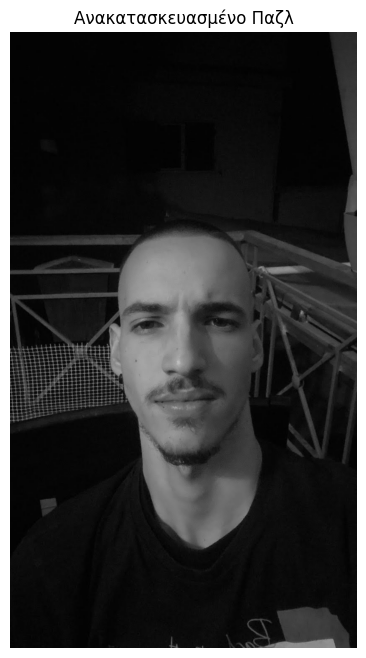

----------------------------------------
ΑΠΟΤΕΛΕΣΜΑΤΑ ΑΞΙΟΛΟΓΗΣΗΣ:
Σωστοί Γείτονες: 12 / 12
Neighbor Accuracy: 100.00%
----------------------------------------


In [6]:
# --- ΤΕΛΙΚΗ ΕΚΤΕΛΕΣΗ ΜΕ DEEP LEARNING & EVALUATION ---

print("1. Υπολογισμός Deep Features για όλα τα κομμάτια...")
print("(Αυτό μπορεί να πάρει 1-2 λεπτά ανάλογα με την ταχύτητα του Colab)...")

# Ξανα-υπολογίζουμε τα features για ΟΛΑ τα κομμάτια.
# Τώρα η συνάρτηση 'process_piece' περιλαμβάνει και το CNN (ResNet)
# που προσθέσαμε στο προηγούμενο βήμα.
for p in pieces:
    extractor.process_piece(p)

print("   -> Ολοκληρώθηκε.")

# --- ΔΗΜΙΟΥΡΓΙΑ ΤΟΥ ΕΞΥΠΝΟΥ SOLVER ---
# Δίνουμε μεγαλύτερο βάρος (0.5) στο Deep Learning γιατί είναι πιο αξιόπιστο
deep_scorer = DeepAdjacencyScorer(w_col=0.3, w_tex=0.2, w_deep=0.5)

print("\n2. Εκκίνηση Deep Solver...")
solver_deep = GreedySolver(pieces, P=3, Q=3, scorer=deep_scorer, extractor=extractor)
solver_deep.solve()

print("\n3. Οπτικοποίηση Αποτελέσματος...")
solver_deep.visualize_solution()

# --- ΑΞΙΟΛΟΓΗΣΗ (EVALUATION METRICS) [cite: 244-249] ---
def evaluate_puzzle(solver):
    """
    Υπολογίζει πόσο σωστό είναι το παζλ με βάση τους γείτονες.
    Ελέγχουμε αν ο δεξιός γείτονας είναι όντως ο σωστός δεξιός γείτονας.
    """
    correct_neighbors = 0
    total_checks = 0

    # Έλεγχος Οριζόντιων Γειτόνων
    for r in range(solver.P):
        for c in range(solver.Q - 1):
            p1 = solver.grid[r][c]
            p2 = solver.grid[r][c+1]
            total_checks += 1
            if p1 and p2:
                # Αν το p2 είναι όντως δεξιά του p1 στο Ground Truth
                if p1.true_grid_pos[0] == p2.true_grid_pos[0] and \
                   p1.true_grid_pos[1] + 1 == p2.true_grid_pos[1]:
                    correct_neighbors += 1

    # Έλεγχος Κάθετων Γειτόνων
    for r in range(solver.P - 1):
        for c in range(solver.Q):
            p1 = solver.grid[r][c]
            p2 = solver.grid[r+1][c]
            total_checks += 1
            if p1 and p2:
                # Αν το p2 είναι όντως κάτω από το p1 στο Ground Truth
                if p1.true_grid_pos[0] + 1 == p2.true_grid_pos[0] and \
                   p1.true_grid_pos[1] == p2.true_grid_pos[1]:
                    correct_neighbors += 1

    accuracy = (correct_neighbors / total_checks) * 100 if total_checks > 0 else 0
    return correct_neighbors, total_checks, accuracy

# Τρέχουμε την αξιολόγηση
correct, total, acc = evaluate_puzzle(solver_deep)
print("-" * 40)
print(f"ΑΠΟΤΕΛΕΣΜΑΤΑ ΑΞΙΟΛΟΓΗΣΗΣ:")
print(f"Σωστοί Γείτονες: {correct} / {total}")
print(f"Neighbor Accuracy: {acc:.2f}%")
print("-" * 40)